In [1]:
# Cell 0: install libs (run once)
!pip install -q xgboost lightgbm shap imbalanced-learn
# (tensorflow is preinstalled in Colab; if you don't have it, uncomment next line)
# !pip install -q tensorflow


In [2]:
# Cell 1: imports and seed
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

# sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb

# For CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [3]:
# Cell 2: load dataset (tries common paths used in Colab environments)
possible_paths = [
    '/content/Breast_cancer_data.csv',
]

df = None
for p in possible_paths:
    if os.path.exists(p):
        df = pd.read_csv(p)
        print("Loaded:", p)
        break

if df is None:
    # prompt user to upload a file
    from google.colab import files
    print("No common path found. Please upload your CSV file now (choose Breast_cancer_data.csv).")
    uploaded = files.upload()
    fname = next(iter(uploaded))
    df = pd.read_csv(fname)
    print("Loaded uploaded file:", fname)

print("Dataset shape:", df.shape)
display(df.head())


Loaded: /content/Breast_cancer_data.csv
Dataset shape: (569, 6)


,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


In [4]:
# Cell 3: EDA and detect the target column
print("Columns:", df.columns.tolist())
print("\nInfo:")
display(df.info())

print("\nMissing values per column:")
display(df.isnull().sum().sort_values(ascending=False).head(20))

# Try to auto-detect a target column by common names
candidates = ['target','diagnosis','label','class','Class','Outcome','y','status','result']
target_col = None
for c in candidates:
    if c in df.columns:
        target_col = c
        break

if target_col is None:
    # fallback: if last column looks binary, use it; else use last column anyway (user can change)
    last_col = df.columns[-1]
    unique_vals = df[last_col].dropna().unique()
    if len(unique_vals) <= 10:  # reasonable for class labels
        target_col = last_col
    else:
        # if nothing sensible, still set last column but tell user to update manually if wrong
        target_col = last_col

print(f"\nAuto-selected target column: '{target_col}'")
print("Unique values in target column (sample):", df[target_col].unique()[:20])


Columns: ['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area', 'mean_smoothness', 'diagnosis']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


None


Missing values per column:


,0
mean_radius,0
mean_texture,0
mean_perimeter,0
mean_area,0
mean_smoothness,0
diagnosis,0



Auto-selected target column: 'diagnosis'
Unique values in target column (sample): [0 1]


In [5]:
# Cell 4: drop obvious ID columns and encode target
df2 = df.copy()

# drop ID columns if present
id_cols = [c for c in df2.columns if c.lower() in ('id','patient_id','pid')]
if id_cols:
    print("Dropping id-like columns:", id_cols)
    df2.drop(columns=id_cols, inplace=True)

# ensure target exists
print("Target column used:", target_col)
if target_col not in df2.columns:
    raise ValueError(f"Target column {target_col} not found. Edit target_col variable.")

# Map common string labels to numeric
y_raw = df2[target_col]
if y_raw.dtype == 'object' or y_raw.dtype.name == 'category':
    # common mapping M/B or malignant/benign
    mapping = {}
    # lower-case representations
    unique_vals = [str(x).lower() for x in y_raw.dropna().unique()]
    if 'm' in unique_vals and 'b' in unique_vals:
        mapping = {'M':1,'m':1,'malignant':1,'Malignant':1,'B':0,'b':0,'benign':0,'Benign':0}
    else:
        # fallback: label encode
        lbl = LabelEncoder()
        df2[target_col] = lbl.fit_transform(y_raw.astype(str))
        print("Label-encoded target classes:", list(lbl.classes_))
        y = df2[target_col].astype(int)
else:
    # assume numeric already
    y = df2[target_col].astype(int)

# if mapping created, apply
if 'mapping' in locals() and mapping:
    df2[target_col] = df2[target_col].map(mapping)
    # if some unmapped remain, label-encode them
    if df2[target_col].isnull().any():
        temp = df2[target_col].astype(str)
        lbl = LabelEncoder()
        df2[target_col] = lbl.fit_transform(temp)
        print("Mixed labels: applied mapping + label encoding; classes:", list(lbl.classes_))
    y = df2[target_col].astype(int)

# show class balance
print("Class distribution (value:count):")
print(y.value_counts().to_dict())

# prepare X (drop target)
X = df2.drop(columns=[target_col])
print("Final feature count:", X.shape[1])


Target column used: diagnosis
Class distribution (value:count):
{1: 357, 0: 212}
Final feature count: 5


In [6]:
# Cell 5: detect numeric/categorical
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()
print("Numeric cols:", len(num_cols))
print("Categorical cols:", len(cat_cols))
print("Example numeric cols:", num_cols[:10])
print("Example categorical cols:", cat_cols[:10])

# missing values
print("\nMissing values (top):")
display(X.isnull().sum().sort_values(ascending=False).head(20))


Numeric cols: 5
Categorical cols: 0
Example numeric cols: ['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area', 'mean_smoothness']
Example categorical cols: []

Missing values (top):


,0
mean_radius,0
mean_texture,0
mean_perimeter,0
mean_area,0
mean_smoothness,0


In [8]:
# Cell 6: Preprocessor and train/test split
# Create transformers only for available columns
transformers = []
if num_cols:
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    transformers.append(('num', num_pipeline, num_cols))

if cat_cols:
    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    transformers.append(('cat', cat_pipeline, cat_cols))

preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    stratify=y, random_state=SEED)
# fit preprocessor on train
preprocessor.fit(X_train)
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# if transform returns pandas or numpy — ensure numpy
import scipy.sparse as sp
if sp.issparse(X_train_proc):
    X_train_proc = X_train_proc.toarray()
    X_test_proc = X_test_proc.toarray()

print("Processed train shape:", X_train_proc.shape, "test shape:", X_test_proc.shape)



Processed train shape: (455, 5) test shape: (114, 5)


In [9]:
# Cell 7: evaluation helpers
def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title(title)
    plt.show()

def model_metrics(y_true, y_pred, y_score):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_score)
    return dict(accuracy=acc, precision=prec, recall=rec, f1=f1, roc_auc=roc)

def plot_roc_pr(y_true, y_score, title_prefix="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'k--', alpha=0.4)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} - ROC curve")
    plt.legend(); plt.show()

    prec, rec, _ = precision_recall_curve(y_true, y_score)
    plt.figure(figsize=(6,4))
    plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"{title_prefix} - Precision-Recall curve")
    plt.show()




==== Training: LogisticRegression ====
Accuracy: 0.8596  Precision: 0.9375  Recall: 0.8333  F1: 0.8824  ROC_AUC: 0.9719

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.90      0.83        42
           1       0.94      0.83      0.88        72

    accuracy                           0.86       114
   macro avg       0.85      0.87      0.85       114
weighted avg       0.87      0.86      0.86       114



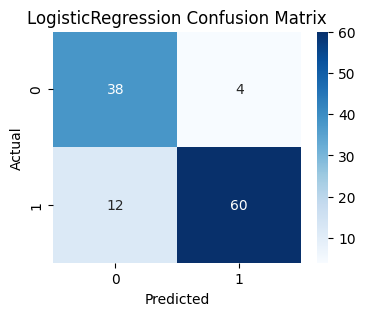

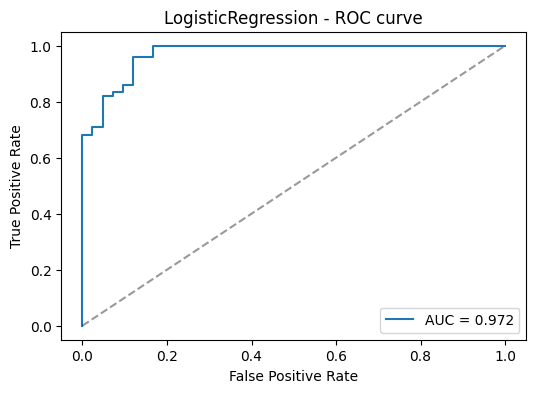

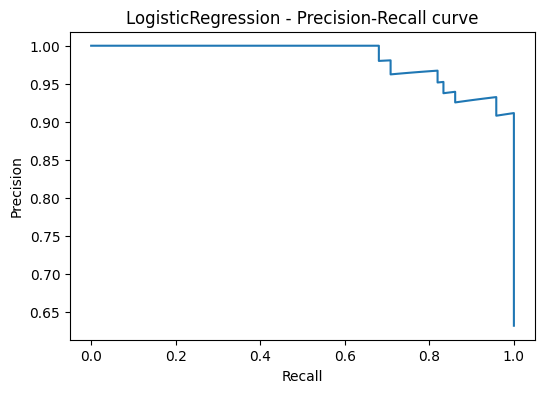



==== Training: SVM ====
Accuracy: 0.8772  Precision: 0.9531  Recall: 0.8472  F1: 0.8971  ROC_AUC: 0.9706

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        42
           1       0.95      0.85      0.90        72

    accuracy                           0.88       114
   macro avg       0.87      0.89      0.87       114
weighted avg       0.89      0.88      0.88       114



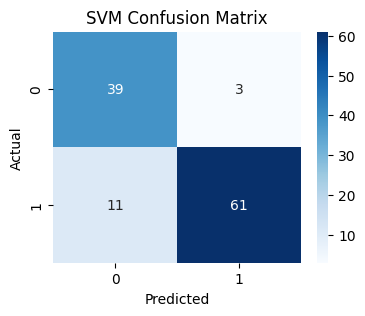

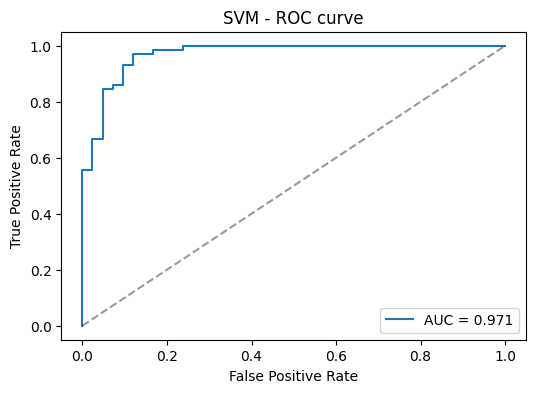

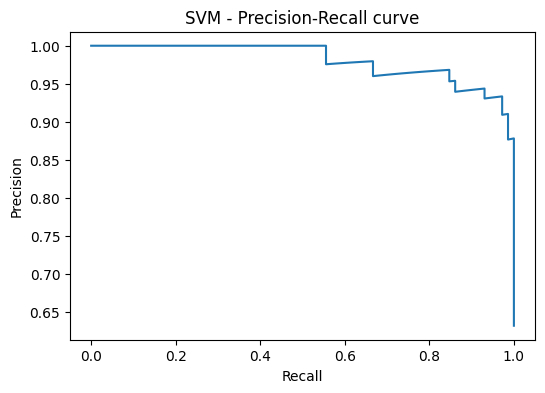



==== Training: DecisionTree ====
Accuracy: 0.8860  Precision: 0.9538  Recall: 0.8611  F1: 0.9051  ROC_AUC: 0.8948

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86        42
           1       0.95      0.86      0.91        72

    accuracy                           0.89       114
   macro avg       0.87      0.89      0.88       114
weighted avg       0.90      0.89      0.89       114



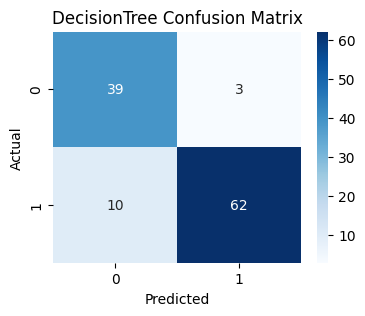

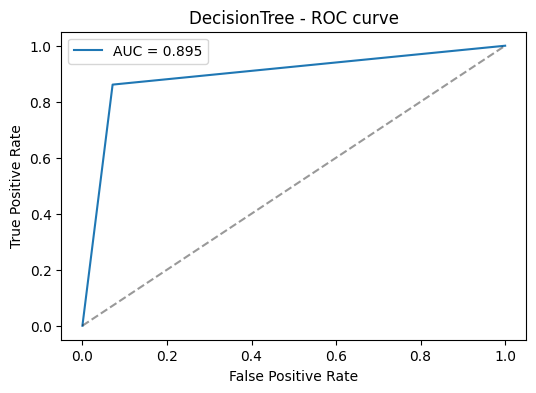

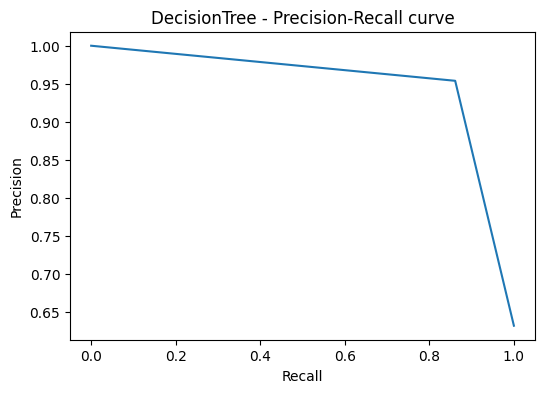



==== Training: RandomForest ====
Accuracy: 0.9211  Precision: 0.9565  Recall: 0.9167  F1: 0.9362  ROC_AUC: 0.9691

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        42
           1       0.96      0.92      0.94        72

    accuracy                           0.92       114
   macro avg       0.91      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114



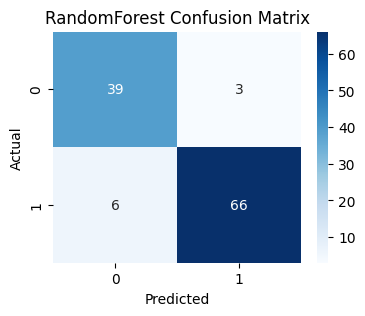

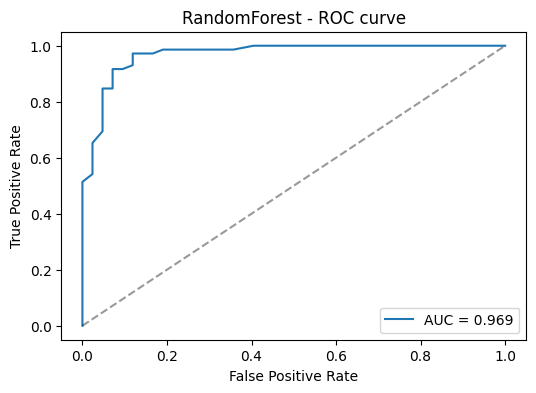

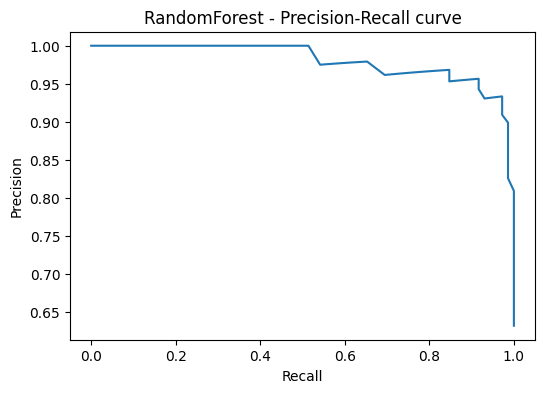



==== Training: GaussianNB ====
Accuracy: 0.8947  Precision: 0.9054  Recall: 0.9306  F1: 0.9178  ROC_AUC: 0.9643

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        42
           1       0.91      0.93      0.92        72

    accuracy                           0.89       114
   macro avg       0.89      0.88      0.89       114
weighted avg       0.89      0.89      0.89       114



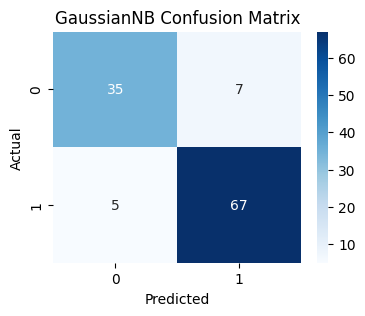

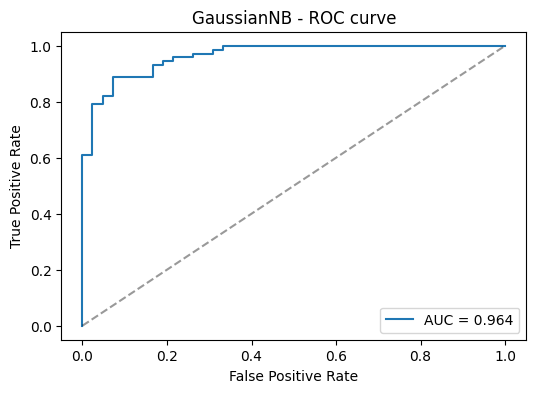

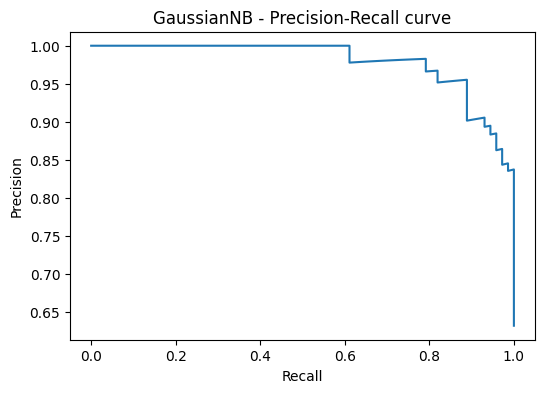



==== Training: XGBoost ====
Accuracy: 0.8947  Precision: 0.9545  Recall: 0.8750  F1: 0.9130  ROC_AUC: 0.9651

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        42
           1       0.95      0.88      0.91        72

    accuracy                           0.89       114
   macro avg       0.88      0.90      0.89       114
weighted avg       0.90      0.89      0.90       114



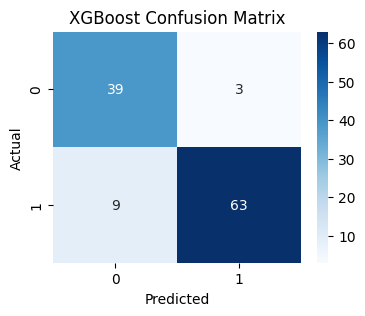

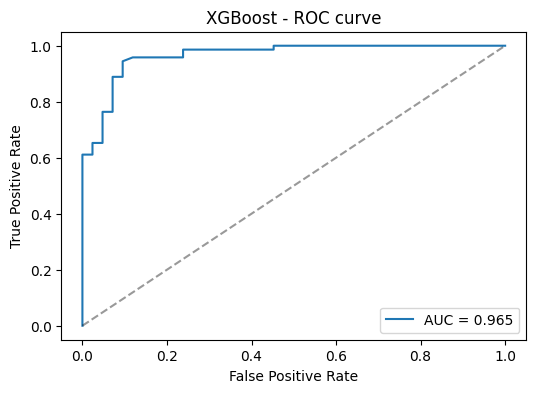

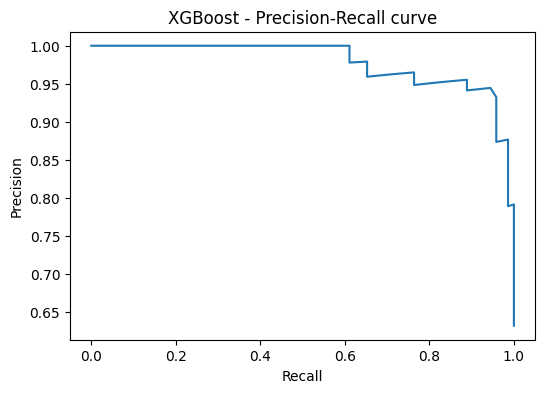



==== Training: LightGBM ====
[LightGBM] [Info] Number of positive: 285, number of negative: 170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626374 -> initscore=0.516691
[LightGBM] [Info] Start training from score 0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

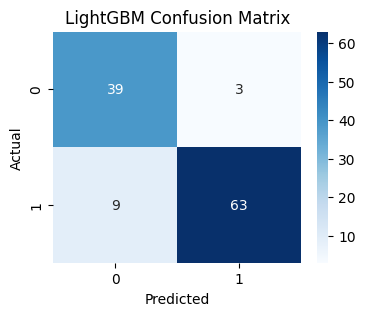

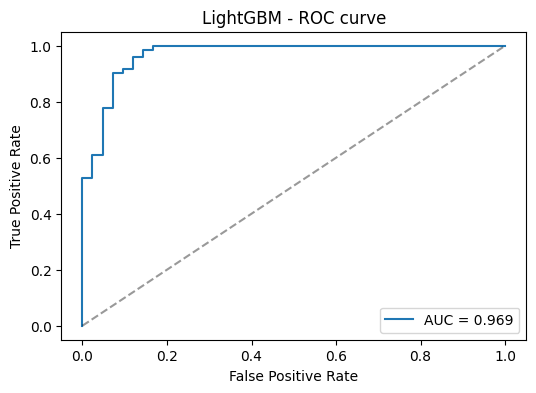

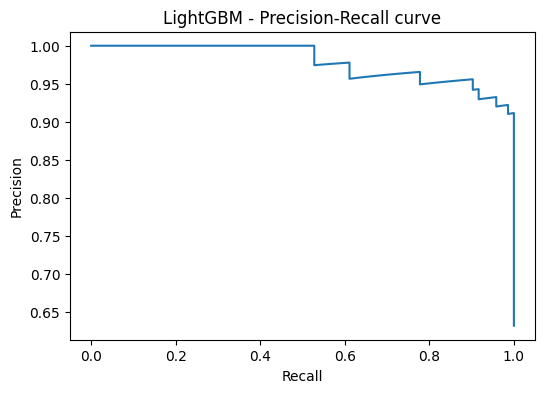



==== Training: MLP ====
Accuracy: 0.8684  Precision: 0.9524  Recall: 0.8333  F1: 0.8889  ROC_AUC: 0.9712

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.93      0.84        42
           1       0.95      0.83      0.89        72

    accuracy                           0.87       114
   macro avg       0.86      0.88      0.86       114
weighted avg       0.88      0.87      0.87       114



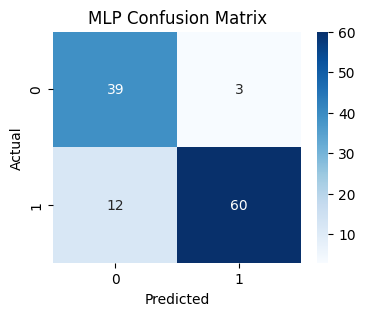

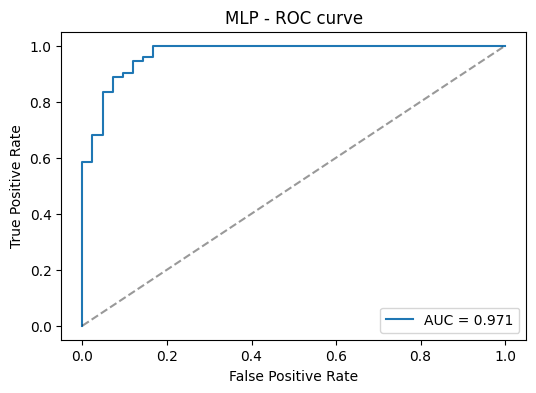

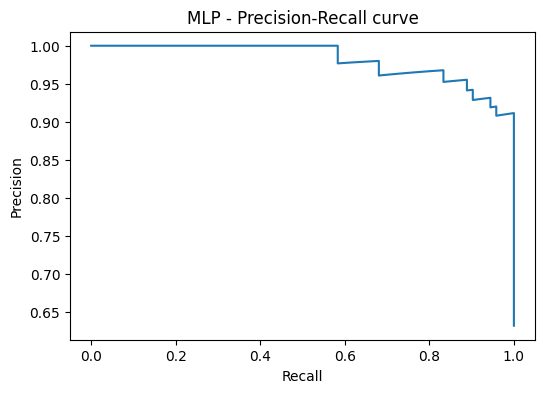

,accuracy,precision,recall,f1,roc_auc
model,,,,,
LogisticRegression,0.859649,0.937500,0.833333,0.882353,0.971892
MLP,0.868421,0.952381,0.833333,0.888889,0.971230
SVM,0.877193,0.953125,0.847222,0.897059,0.970569
RandomForest,0.921053,0.956522,0.916667,0.936170,0.969081
LightGBM,0.894737,0.954545,0.875000,0.913043,0.968585
XGBoost,0.894737,0.954545,0.875000,0.913043,0.965112
GaussianNB,0.894737,0.905405,0.930556,0.917808,0.964286
DecisionTree,0.885965,0.953846,0.861111,0.905109,0.894841


In [10]:
# Cell 8: define models and run them
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=SEED),
    'SVM': SVC(probability=True, random_state=SEED),
    'DecisionTree': DecisionTreeClassifier(random_state=SEED),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1),
    'GaussianNB': GaussianNB(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED, n_jobs=-1),
    'LightGBM': lgb.LGBMClassifier(random_state=SEED, n_jobs=-1),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=SEED)
}

results = []
fitted_models = {}

for name, model in models.items():
    print("\n\n==== Training:", name, "====")
    model.fit(X_train_proc, y_train)
    # get probabilities / decision func
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_proc)[:,1]
    else:
        # SVM decision_function returns margin — convert to probability-like by minmax scaling for metrics that need it
        try:
            y_score = model.decision_function(X_test_proc)
        except:
            y_score = model.predict(X_test_proc)
    y_pred = model.predict(X_test_proc)
    met = model_metrics(y_test, y_pred, y_score)
    print("Accuracy: {:.4f}  Precision: {:.4f}  Recall: {:.4f}  F1: {:.4f}  ROC_AUC: {:.4f}".format(
          met['accuracy'], met['precision'], met['recall'], met['f1'], met['roc_auc']))
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))
    plot_confusion(y_test, y_pred, title=f"{name} Confusion Matrix")
    plot_roc_pr(y_test, y_score, title_prefix=name)

    results.append((name, met))
    fitted_models[name] = model

# Summary table
summary = pd.DataFrame([{ 'model': name, **metrics } for name, metrics in results])
summary = summary.set_index('model')
display(summary.sort_values(by='roc_auc', ascending=False))
